## Import libraries

In [2]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

%matplotlib inline

/Users/ryanneal/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Functions

In [3]:
def survive_prob(data_set, column):
    return data_set[[column, 'Survived']].groupby([column], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [4]:
def correlation(data1, data2):
    return np.corrcoef(data1['Value'].values, data2['Value'].values)

## Ingest data

In [5]:
train_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv"
train = pd.read_csv(train_url, index_col = 0)
test_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv"
test = pd.read_csv(test_url, index_col = 0)
full_data = pd.concat([train, test])

## Explore data

In [6]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.shape

(891, 11)

In [8]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


- 177 missing ages
- 2 missing embarks
- 615 missing cabins

## Thoughts

- cabin has many missing values, so we will delete it
- will fill ages with median age
- for the rest of the features, we will check correlations


## analyze gender

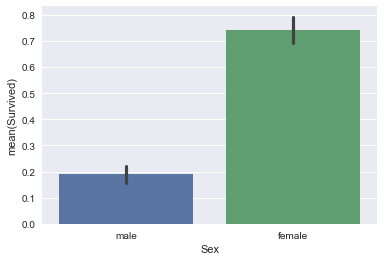

In [10]:
sns.barplot(x="Sex", y="Survived", data=train )

In [11]:
train["Survived"].value_counts(normalize="true")

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [12]:
train["Survived"][train["Sex"]=="male"].value_counts()

0    468
1    109
Name: Survived, dtype: int64

In [13]:
train["Survived"][train["Sex"]=="male"].value_counts(normalize="true")

0    0.811092
1    0.188908
Name: Survived, dtype: float64

In [14]:
train["Survived"][train["Sex"]=="female"].value_counts()

1    233
0     81
Name: Survived, dtype: int64

In [15]:
train["Survived"][train["Sex"]=="female"].value_counts(normalize="true")

1    0.742038
0    0.257962
Name: Survived, dtype: float64

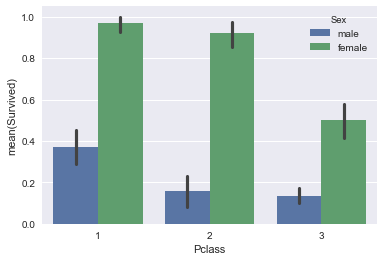

In [16]:
sns.barplot(x="Pclass", y="Survived", hue= "Sex", data=train )

## Thoughts on gender

- gender appears valid. We will use this feature
- male will equal 0
- female will equal 1

## analyze age

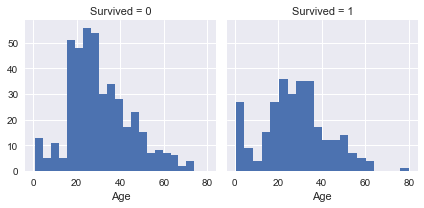

In [17]:
age_plots = sns.FacetGrid(train, col='Survived')
age_plots.map(plt.hist, 'Age', bins=20)

## Create bins for ages

- 0 - 5 = 0
- 6 - 12 = 1
- 13 - 20 = 2
- 21 - 35 = 3
- 35 - 50 = 4
- 51 - 65 = 5
- 65+ = 6

## analyze fare

In [18]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## Thoughts on fare

- cut cells into quartiles

## Analyze embarked

In [19]:
train["Survived"][train["Embarked"]=="S"].value_counts(normalize = "True")

0    0.663043
1    0.336957
Name: Survived, dtype: float64

In [20]:
train["Survived"][train["Embarked"]=="C"].value_counts(normalize = "True")

1    0.553571
0    0.446429
Name: Survived, dtype: float64

In [21]:
train["Survived"][train["Embarked"]=="Q"].value_counts(normalize = "True")

0    0.61039
1    0.38961
Name: Survived, dtype: float64

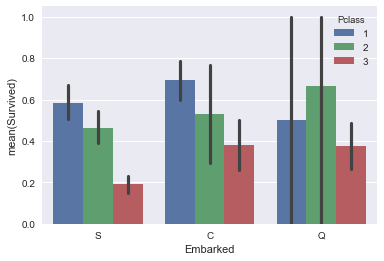

In [22]:
sns.barplot(x="Embarked", y="Survived", hue="Pclass", data=train )

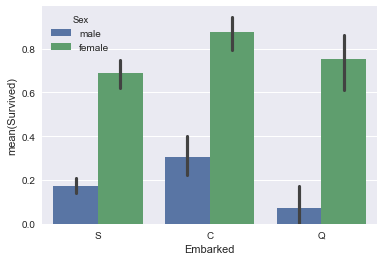

In [23]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train )

## Thoughts on embarked

- Patients from Cherbourgh, France had by far the highest survival. This is likely due to the higher proportion of 1st class passengers
- Queenstown, Ireland and Southampton, England were close

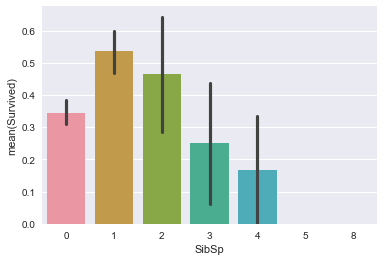

In [24]:
sns.barplot(x="SibSp", y="Survived", data=train )

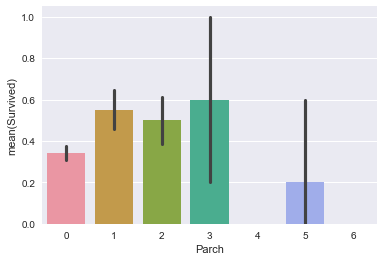

In [25]:
sns.barplot(x="Parch", y="Survived", data=train )

In [26]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Functions for transforming data

In [27]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
#transform sex
def transform_sex(data):
    data.Sex = data.Sex.map({"female":1, "male":0}).astype(int)
    return data

In [29]:
#transform age
def transform_age(data):
    data.Age = data.Age.fillna(-1)
    bins = [-2, 0, 5, 12, 20, 35, 50, 65, 120]
    group_names = [-1, 0, 1, 2, 3, 4, 5, 6]
    data.Age = pd.cut(data.Age, bins, labels=group_names)
    data.Age = data.Age.astype(int)
    return data

In [30]:
def create_family_size(data):
    data["Family_Size"] = data.SibSp + data.Parch + 1
    return data

In [31]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [32]:
def transform_cabin(data):
    data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in data['Cabin'] ])
    data = pd.get_dummies(data, columns = ["Cabin"],prefix="Cabin")
    return data

In [33]:
def is_solo(data):
    data["Is_Solo"] = float('NaN')
    data.Is_Solo = data.Is_Solo[data.Family_Size == 1] = 1
    data.Is_Solo = data["Is_Solo"][data.Family_Size > 1] = 0
    return data

In [34]:
#transform fare
def transform_fare(data):
    numbers = [0, 1, 2, 3]
    bins = [-1, 7.91,14.454, 31, 513]
    data.Fare = pd.cut(data.Fare, bins, labels = numbers)
    data.Fare = data.Fare.astype(int)
    return data

In [35]:
#transform family size
def transform_family(data):
    numbers = [0, 1, 2, 3, 4]
    bins = [-1, 1, 2, 3, 4, 100]
    data.Family_Size = pd.cut(data.Family_Size, bins, labels = numbers)
    data.Family_Size = data.Family_Size.astype(int)
    return data

In [36]:
def transform_embarked(data):
    data.Embarked.fillna("S", inplace = "True")
    data.Embarked = data.Embarked.map({"S":0, "C":1, "Q":2}).astype(int)
    return data

In [37]:
def create_title(data):
    data["Title"] = data.Name.apply(lambda x: x.split(' ')[1])
    return data

In [38]:
def convert_titles(data):
    Title_Dictionary = {
                    "Mme.":        int(3),
                    "Mlle.":       int(4),
                    "Ms.":         int(3),
                    "Mr." :        int(1),
                    "Mrs." :       int(3),
                    "Miss." :      int(4),
                    "Master." :    int(2),
                    }

    data.Title = data.Title.map(Title_Dictionary)    
    data.Title.fillna(0, inplace="true")
    return data


In [39]:
def drop_features(data):
    return data.drop(['Ticket', 'Name', 'Cabin'], axis=1)

In [40]:
def transform_data(data):
    new_data = data.copy()
    new_data = transform_sex(new_data)
    new_data = transform_age(new_data)
    new_data = transform_fare(new_data)
    new_data = create_family_size(new_data)
    new_data = transform_family(new_data)
    new_data = transform_embarked(new_data)
    new_data = create_title(new_data)
    new_data = convert_titles(new_data)
    new_data = drop_features(new_data)
    #new_data = transform_cabin(new_data)
    #new_data = is_solo(new_data)
    return new_data

## Transform full data

In [51]:
the_X = transform_data(train)

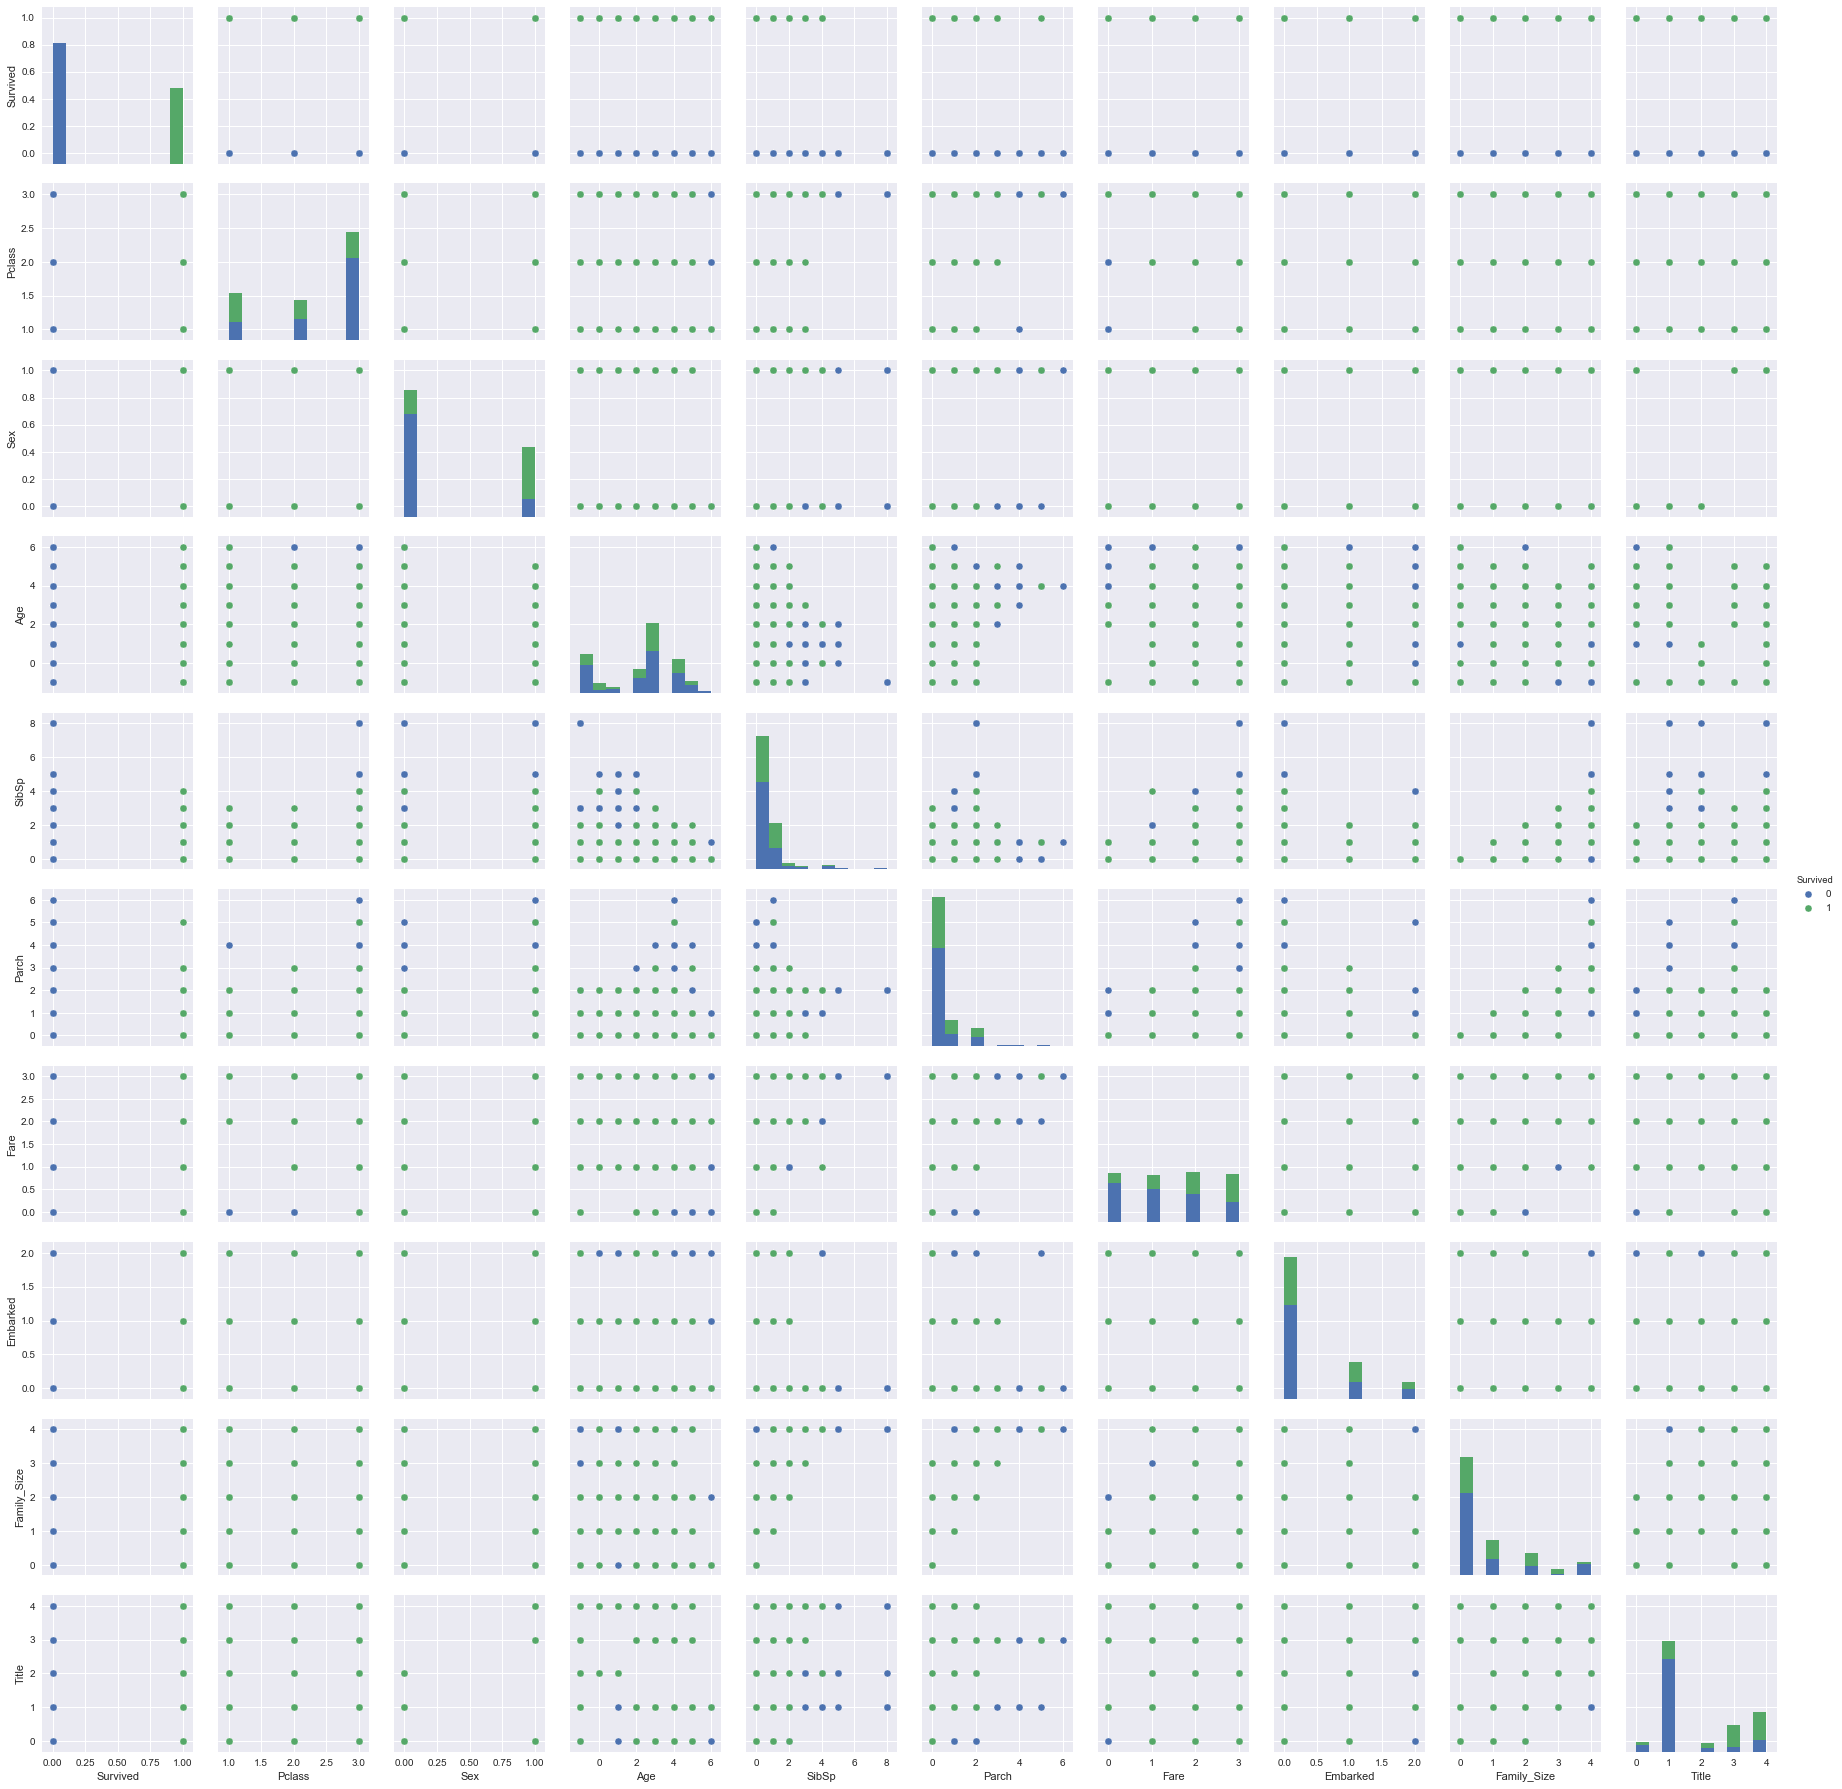

In [52]:
sns.pairplot(the_X, hue="Survived")

In [43]:
the_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int64
Embarked       891 non-null int64
Family_Size    891 non-null int64
Title          891 non-null float64
dtypes: float64(1), int64(9)
memory usage: 76.6 KB


In [44]:
the_y = train.Survived

In [45]:
the_X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size,Title
PassengerId,,,,,,,,,,
1,0,3,0,3,1,0,0,0,1,1.0
2,1,1,1,4,1,0,3,1,1,3.0
3,1,3,1,3,0,0,1,0,0,4.0
4,1,1,1,3,1,0,3,0,1,3.0
5,0,3,0,3,0,0,1,0,0,1.0


In [46]:
the_X = the_X.drop("Survived", axis = 1)

In [47]:
train_X , test_X , train_y , test_y = train_test_split( the_X , the_y , test_size = .25 )

NameError: name 'train_test_split' is not defined

## Models

### Logistic Regression

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(train_X, train_y)

In [ ]:
y_pred = logreg.predict(test_X)

In [ ]:
metrics.accuracy_score(test_y, y_pred)

In [ ]:
print('True:', test_y.values[0:25])
print('Pred:', y_pred[0:25])

In [ ]:
print(metrics.confusion_matrix(test_y, y_pred))

In [ ]:
score = cross_val_score(logreg, the_X, the_y, cv=10, scoring="accuracy")

In [ ]:
print(score.mean())

### KNN

In [ ]:
knn_range = list(range(1,31))
knn_score = []
for k in knn_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, the_X, the_y, cv=10, scoring="accuracy")
    knn_score.append(score.mean())
    

In [ ]:
plt.plot(knn_range, knn_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
knn_score

In [ ]:
# 9 is the best
knn = KNeighborsClassifier(n_neighbors=9)
score = cross_val_score(knn, the_X, the_y, cv=10, scoring="accuracy")
print(score.mean())

- KNN of 9 gives best score. Better than logistic regression

In [ ]:
false_negative.info()

In [ ]:
false_positive.info()

In [ ]:
param_grid= dict(n_neighbors=knn_range)

In [ ]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring="accuracy")

In [ ]:
grid.fit(the_X, the_y)

In [ ]:
# confirmation 9 is best with grid scores
grid.grid_scores_

In [ ]:
print(grid.best_score_)

In [ ]:
print(grid.best_estimator_)

In [ ]:
print(grid.best_params_)

In [ ]:
weight_options = ['uniform', 'distance']

In [ ]:
param_grid2 = dict(n_neighbors=knn_range, weights=weight_options)

In [ ]:
grid = GridSearchCV(knn, param_grid2, cv=10, scoring="accuracy")

In [ ]:
grid.fit(the_X, the_y)

In [ ]:
grid.grid_scores_

In [ ]:
print(grid.best_params_)

- uniform is better

In [ ]:
the_X.head()

## Reevaluate

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7 )
knn.fit(train_X, train_y)
pred_y = knn.predict(test_X)

In [ ]:
print('True:', test_y.values[0:25])
print('Pred:', pred_y[0:25])

In [ ]:
frame1 = pd.DataFrame(test_y + pred_y)

x = frame1[frame1.Survived == 1]

new_frame = pd.merge(x, train, how='inner', on=None, left_on=None, right_on=None,
         left_index=True, right_index=True, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)

false_negative = new_frame[new_frame.Survived_y == 1]

false_positive = new_frame[new_frame.Survived_y == 0]

In [ ]:
false_negative.info()

In [ ]:
false_positive.info()

In [ ]:
false_positive.describe()

In [ ]:
false_negative.describe()

In [ ]:
q = sns.heatmap(new_frame[["Survived_y","SibSp","Parch","Age","Fare", "Pclass"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [ ]:
g = sns.factorplot(x="SibSp",y="Survived_y",data=new_frame,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("false probability")

In [ ]:
new_frame.SibSp

In [ ]:
train.SibSp

In [ ]:
new_frame.SibSp.value_counts()

In [ ]:
train.SibSp.value_counts()

In [ ]:
new_frame.Fare.value_counts(sort="true")

In [ ]:
g = sns.FacetGrid(new_frame, col='Survived_y')
g = g.map(sns.distplot, "Age")

In [ ]:
new_frame

In [ ]:
train.loc[80]

In [ ]:
g = sns.factorplot(x="Sex",y="Survived_y",data=new_frame,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("false probability")

In [ ]:
new_frame.Sex.value_counts()

In [ ]:
train.Sex.value_counts()

In [ ]:
train.Age.isnull().sum()/len(train)

In [ ]:
new_frame.Age.isnull().sum()/len(new_frame)

In [ ]:
g = sns.factorplot(x="Parch",y="Survived_y",data=new_frame,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("false probability")

In [ ]:
new_frame.Parch.value_counts()

In [ ]:
train.Parch.value_counts()

In [ ]:
new_frame.SibSp.value_counts()

In [ ]:
train.SibSp.value_counts()